In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.core import *
from fastai.io import *
from fastai.dataloader import *
from fastai.conv_learner import *
from fastai.learner import *
import os

import IPython.display as ipd

In [2]:
import librosa

## Load Data

In [3]:
PATH = Path('data/freesound')
TRN_PATH = PATH/'audio_train'
TEST_PATH = PATH/'audio_test'

In [4]:
list(PATH.iterdir())

[PosixPath('data/freesound/sample_submission.csv'),
 PosixPath('data/freesound/models'),
 PosixPath('data/freesound/train.csv'),
 PosixPath('data/freesound/audio_train'),
 PosixPath('data/freesound/audio_test'),
 PosixPath('data/freesound/tmp')]

In [5]:
trn = pd.read_csv(PATH/'train.csv')
test = pd.read_csv(PATH/'sample_submission.csv')

In [6]:
trn.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [7]:
trn.shape[0], len(trn.label.unique())

(9473, 41)

In [8]:
fnames = list(trn['fname']) 
len(fnames), fnames[:5]

(9473,
 ['00044347.wav',
  '001ca53d.wav',
  '002d256b.wav',
  '0033e230.wav',
  '00353774.wav'])

In [9]:
def adj_length(raw):
    raw_max = np.argmax(raw)
    start = max(0, (raw_max-65535))
    end = raw_max+65535
    if end < 131070:
        raw = np.pad(raw, (131070-end), 'constant')
        end = raw_max+65535
    raw_s = raw[start:end]
    return raw_s

In [10]:
import librosa

# functions to produce melspectrogram in shape [1,1,256,256]; probably should be a class
# I adjusted the n-mels to 256, but left the hop_length and n_fft the same; not sure how
# that affects the quality of the spectrogram

def open_audio(fn, sr=None):
    """Opens audio file using Librosa given the file path
    
    Arguments:
        fn: the file path for the audio
        
    Returns:
        The audio as a numpy array (TODO: of floats normalized to range between 0.0 - 1.0)
        and sampling rate
    """
    #flags = TODO
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            aud, sr = librosa.load(str(fn), sr=sr)#.astype(np.float32)
            if aud is None: raise OSError(f'File not recognized by librosa: {fn}')
            return aud, sr
        except Exception as e:
            raise OSError('Error handling audio at: {}'.format(fn)) from e


input_length=131070

# combination of weak-feature-extractor and kaggle starter kernel;
def get_mel(fn, sr=None, input_length=input_length, n_fft=1024, hop_length=512, n_mels=256):
    y, sr = open_audio(fn, sr)
    y = adj_length(y)
    """
    # from kaggle starter kernel
    if len(y) > input_length:
            max_offset = len(y) - input_length
            offset = np.random.randint(max_offset)
            y = y[offset:(input_length+offset)]
    else:
        if input_length > len(y):
            max_offset = input_length - len(y)
            offset = np.random.randint(max_offset)
        else:
            offset = 0
        y = np.pad(y, (offset, input_length - len(y) - offset), "constant")
    """
    mel_feat = librosa.feature.melspectrogram(y,sr,n_fft=n_fft,hop_length=hop_length,n_mels=n_mels)
    inpt = librosa.power_to_db(mel_feat).T

    #quick hack for now
    if inpt.shape[0] < 128:
        inpt = np.concatenate((inpt,np.zeros((128-inpt.shape[0],n_mels))),axis=0)

    # input needs to be 4D, batch_size X 1 X input_size[0] X input_size[1]
    inpt = np.reshape(inpt,(1,1,inpt.shape[0],inpt.shape[1]))
    return inpt

# returns melspectrogram in shape [1,1,256,256]
def get_audio(path, sr=None): return get_mel(str(path), sr)

In [194]:
get_mel(next(trn_wavs))

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/librosa/filters.py:271: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


array([[[[-71.25745, -71.25745, -71.25745, ..., -71.25745, -71.25745, -71.25745],
         [-71.25745, -71.25745, -71.25745, ..., -71.25745, -71.25745, -71.25745],
         [-71.25745, -71.25745, -71.25745, ..., -71.25745, -71.25745, -71.25745],
         ..., 
         [-71.25745, -29.08671, -23.90348, ..., -70.5953 , -71.25745, -71.25745],
         [-71.25745, -32.2614 , -27.07816, ..., -71.25745, -71.25745, -71.25745],
         [-71.25745, -32.86619, -27.68295, ..., -71.25745, -71.25745, -71.25745]]]])

### Distribution of Categories

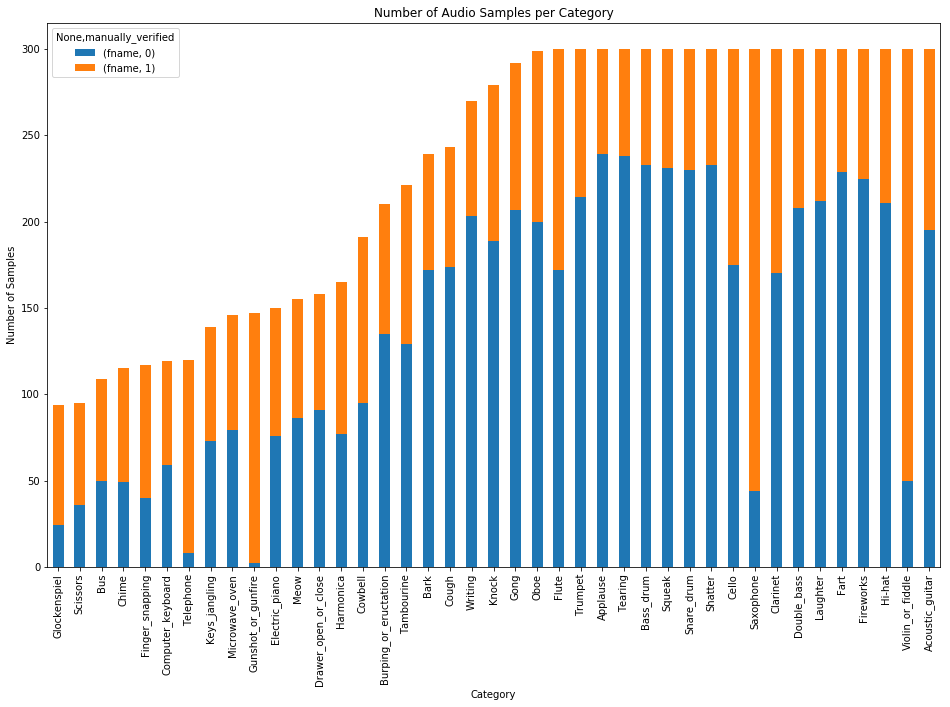

In [11]:
cat_grp = trn.groupby(['label', 'manually_verified']).count()
plot = cat_grp.unstack().reindex(cat_grp.unstack().sum(axis=1).sort_values().index).plot(
    kind='bar', stacked=True, title='Number of Audio Samples per Category', figsize=(16,10))
plot.set_xlabel('Category')
plot.set_ylabel('Number of Samples');

Fairly small percentage of "manually verified" sound clips.

In [12]:
print('Minimum samples in a category:', min(trn.label.value_counts()))
print('Maximum samples in a category:', max(trn.label.value_counts()))

Minimum samples in a category: 94
Maximum samples in a category: 300


In [13]:
import wave

f = str(PATH/'audio_train/001ca53d.wav')
wav = wave.open(f)
print('Sampling (frame) rate:', wav.getframerate())
print('Total samples (frames):', wav.getnframes())
print('Duration:', wav.getnframes()/wav.getframerate())

Sampling (frame) rate: 44100
Total samples (frames): 455112
Duration: 10.32


In [14]:
#import torchaudio -- torchaudio not available in Fastai environment
# using scipy
from scipy.io import wavfile
rate, data = wavfile.read(f)
print('Sampling (frame) rate:', rate)
print('Total samples (frames):', data.shape)
print(data)

Sampling (frame) rate: 44100
Total samples (frames): (455112,)
[-33 -32 -34 ...,  -1  -1  -1]


Plot audio frames

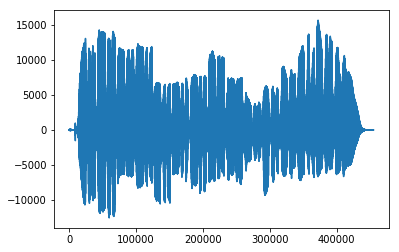

In [15]:
plt.plot(data, '-', );

Zoom in to view 250 frames

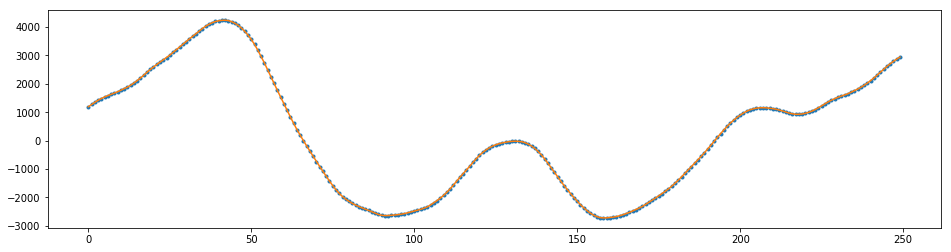

In [16]:
plt.figure(figsize=(16,4))
plt.plot(data[25250:25500], '.'); plt.plot(data[25250:25500], '-');

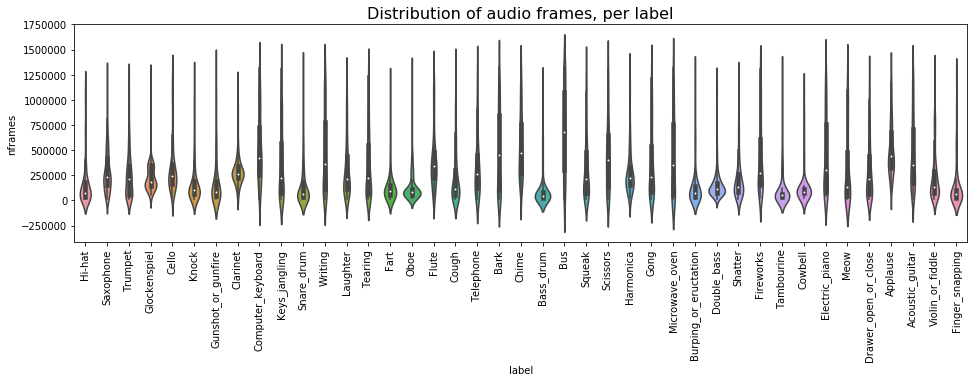

In [17]:
trn['nframes'] = trn['fname'].apply(lambda f: wave.open('data/freesound/audio_train/'+f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('data/freesound/audio_test/'+f).getnframes())

_,ax = plt.subplots(figsize=(16,4))
sns.violinplot(ax=ax, x='label', y='nframes', data=trn)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

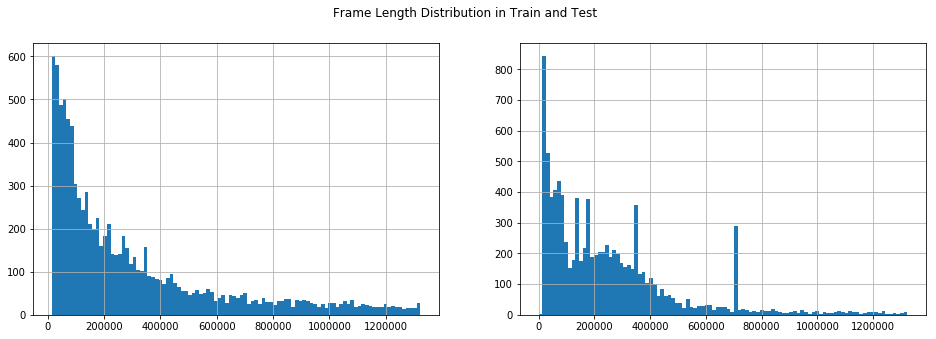

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
trn.nframes.hist(bins=100, ax=axes[0])
test.nframes.hist(bins=100, ax=axes[1])
plt.suptitle("Frame Length Distribution in Train and Test", ha='center', fontsize='large');

1. The majority of frame lengths are short.
2. There are 4 abnormal lengths in test set. Let's analyze them.

### Listen to Sounds

In [19]:
from librosa import display

In [20]:
trn_wavs = (PATH/'audio_train').glob('*.wav')
test_wavs = (PATH/'audio_test').glob('*.wav')

In [21]:
sample = next(trn_wavs)
raw, _ = open_audio(sample)
raw_max = np.argmax(raw)
print('raw length:', len(raw), 'raw_max:', raw_max)
start = max(0, (raw_max-65535))
end = raw_max+65535
if end < 131070:
    raw = np.pad(raw, (131070-end), 'constant')
    end = raw_max+65535
raw_s = raw[start:end]
print('sample length: ', len(raw_s))
s_label = str(sample).split('/')[-1]
print(trn[['label', 'manually_verified']].iloc[fnames.index(s_label)])
ipd.Audio(raw_s, rate=44100)

raw length: 84672 raw_max: 43942
sample length:  109477
label                Knock
manually_verified        0
Name: 6135, dtype: object


In [33]:
aud = get_audio(next(trn_wavs)); aud.shape

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/librosa/filters.py:271: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


(1, 1, 139, 256)

TODO: Warning suggests there is a problem with melspectrogram parameters. Also, I thought I had it worked out so that it would return a square melspectrogram for each image [256,256], but it's not working out that way. Some are, but many are not.

## Model

In [34]:
classes = trn.label.unique(); classes

array(['Hi-hat', 'Saxophone', 'Trumpet', 'Glockenspiel', 'Cello', 'Knock', 'Gunshot_or_gunfire', 'Clarinet',
       'Computer_keyboard', 'Keys_jangling', 'Snare_drum', 'Writing', 'Laughter', 'Tearing', 'Fart', 'Oboe',
       'Flute', 'Cough', 'Telephone', 'Bark', 'Chime', 'Bass_drum', 'Bus', 'Squeak', 'Scissors', 'Harmonica',
       'Gong', 'Microwave_oven', 'Burping_or_eructation', 'Double_bass', 'Shatter', 'Fireworks', 'Tambourine',
       'Cowbell', 'Electric_piano', 'Meow', 'Drawer_open_or_close', 'Applause', 'Acoustic_guitar',
       'Violin_or_fiddle', 'Finger_snapping'], dtype=object)

In [35]:
classes_dict = {}
for i,c in enumerate(classes):
    classes_dict[c] = one_hot(i, len(classes))

In [36]:
ls = []
for l in trn['label'].values:
    ls.append(classes_dict[l])

In [37]:
y = np.array(ls); y.shape

(9473, 41)

In [38]:
idxs = get_cv_idxs(len(y))

## Simplenet

### ImageClassifier Data Method

In [40]:
stats = (np.array([-39.29504]), np.array([14.3013]))

In [41]:
sz=128
# TODO: convert for audio
tfms = tfms_from_stats(stats, sz, aug_tfms=None, pad=sz//8)
data = ImageClassifierData.from_names_and_array(TRN_PATH, fnames, y, classes, val_idxs=idxs, bs=4, tfms=tfms)



### Model

In [50]:
class SimpleConv(nn.Module):
    def __init__(self, ic, oc, ks=3, drop=0.2, bn=True):
        super().__init__()
        self.conv = nn.Conv2d(ic, oc, ks, padding=(ks-1)//2)
        self.bn = nn.BatchNorm2d(oc, momentum=0.05) if bn else None
        self.drop = nn.Dropout(drop, inplace=True)
        self.act = nn.ReLU(True)
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn: x = self.bn(x)
        return self.drop(self.act(x))

In [51]:
net = nn.Sequential(
    SimpleConv(1, 64),
    SimpleConv(64, 128),
    SimpleConv(128, 128),
    SimpleConv(128, 128),
    nn.MaxPool2d(2),
    SimpleConv(128, 128),
    SimpleConv(128, 128),
    SimpleConv(128, 256),
    nn.MaxPool2d(2),
    SimpleConv(256, 256),
    SimpleConv(256, 256),
    nn.MaxPool2d(2),
    SimpleConv(256, 512),
    SimpleConv(512, 2048, ks=1, bn=False),
    SimpleConv(2048, 256, ks=1, bn=False),
    nn.MaxPool2d(2),
    SimpleConv(256, 256, bn=False, drop=0),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(256, 41)
).cuda()

### Fastai version AudioData Class

In [49]:
class FilesDataset(BaseDataset):
    def __init__(self, fnames, transform, path):
        self.path,self.fnames = path,fnames
        super().__init__(transform)
    def get_sz(self): pass #return self.transform.sz
    def get_x(self, i): get_audio(os.path.join(self.path, self.fnames[i]), sr=None)
        # from Image Dataset
        # return open_image(os.path.join(self.path, self.fnames[i]))
    def get_n(self): return len(self.fnames)

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

class FilesArrayDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return self.y[i]
    def get_c(self):
        return self.y.shape[1] if len(self.y.shape)>1 else 0

class FilesIndexArrayDataset(FilesArrayDataset):
    def get_c(self): return int(self.y.max())+1


class FilesNhotArrayDataset(FilesArrayDataset):
    @property
    def is_multi(self): return True


class FilesIndexArrayRegressionDataset(FilesArrayDataset):
    def is_reg(self): return True

class ArraysDataset(BaseDataset):
    def __init__(self, x, y, transform):
        self.x,self.y=x,y
        assert(len(x)==len(y))
        super().__init__(transform)
    def get_x(self, i): return self.x[i]
    def get_y(self, i): return self.y[i]
    def get_n(self): return len(self.y)
    def get_sz(self): return self.x.shape[1]


class ArraysIndexDataset(ArraysDataset):
    def get_c(self): return int(self.y.max())+1
    def get_y(self, i): return self.y[i]


class ArraysNhotDataset(ArraysDataset):
    def get_c(self): return self.y.shape[1]
    @property
    def is_multi(self): return True
    
class ModelData():
    def __init__(self, path, trn_dl, val_dl, test_dl=None):
        self.path,self.trn_dl,self.val_dl,self.test_dl = path,trn_dl,val_dl,test_dl

    @classmethod
    def from_dls(cls, path,trn_dl,val_dl,test_dl=None):
        #trn_dl,val_dl = DataLoader(trn_dl),DataLoader(val_dl)
        #if test_dl: test_dl = DataLoader(test_dl)
        return cls(path, trn_dl, val_dl, test_dl)

    @property
    def is_reg(self): return self.trn_ds.is_reg
    @property
    def is_multi(self): return self.trn_ds.is_multi
    @property
    def trn_ds(self): return self.trn_dl.dataset
    @property
    def val_ds(self): return self.val_dl.dataset
    @property
    def test_ds(self): return self.test_dl.dataset
    @property
    def trn_y(self): return self.trn_ds.y
    @property
    def val_y(self): return self.val_ds.y


class AudioData(ModelData):
    def __init__(self, path, datasets, bs, num_workers, classes):
        trn_ds,val_ds,fix_ds,aug_ds,test_ds,test_aug_ds = datasets
        self.path,self.bs,self.num_workers,self.classes = path,bs,num_workers,classes
        self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl,self.test_dl,self.test_aug_dl = [
            self.get_dl(ds,shuf) for ds,shuf in [
                (trn_ds,True),(val_ds,False),(fix_ds,False),(aug_ds,False),
                (test_ds,False),(test_aug_ds,False)
            ]
        ]

    def get_dl(self, ds, shuffle):
        if ds is None: return None
        return DataLoader(ds, batch_size=self.bs, shuffle=shuffle,
            num_workers=self.num_workers, pin_memory=False)
    
    @property
    def sz(self): return self.trn_ds.sz
    @property
    def c(self): return self.trn_ds.c

    def resized(self, dl, targ, new_path):
        return dl.dataset.resize_imgs(targ,new_path) if dl else None

    def resize(self, targ_sz, new_path='tmp'):
        new_ds = []
        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
        else: dls += [None,None]
        t = tqdm_notebook(dls)
        for dl in t: new_ds.append(self.resized(dl, targ_sz, new_path))
        t.close()
        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)

    @staticmethod
    def get_ds(fn, trn, val, tfms, test=None, **kwargs):
        res = [
            fn(trn[0], trn[1], tfms[0], **kwargs), # train
            fn(val[0], val[1], tfms[1], **kwargs), # val
            fn(trn[0], trn[1], tfms[1], **kwargs), # fix
            fn(val[0], val[1], tfms[0], **kwargs)  # aug
        ]
        if test is not None:
            if isinstance(test, tuple):
                test_lbls = test[1]
                test = test[0]
            else:
                test_lbls = np.zeros((len(test),1))
            res += [
                fn(test, test_lbls, tfms[1], **kwargs), # test
                fn(test, test_lbls, tfms[0], **kwargs)  # test_aug
            ]
        else: res += [None,None]
        return res


class AudioClassifierData(AudioData):
    @classmethod
    def from_names_and_array(cls, path, fnames,y,classes, val_idxs=None, test_name=None,
            num_workers=8, suffix='', tfms=(None,None), bs=64, continuous=False):
        val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
        ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

        test_fnames = read_dir(path, test_name) if test_name else None
        if continuous: f = FilesIndexArrayRegressionDataset
        else:
            f = FilesIndexArrayDataset if len(trn_y.shape)==1 else FilesNhotArrayDataset
        datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                               path=path, test=test_fnames)
        return cls(path, datasets, bs, num_workers, classes=classes) 

### Simple AudioData Class

In [ ]:
str(PATH/fnames[0])

In [ ]:
class AudioData(Dataset):
    def __init__(self, path, fnames, y, transform=None):
        self.path, self.fnames, self.y, self.transform = path, fnames, y, transform
        
    def __len__(self): return len(self.y)
    
    def __getitem__(self,idx):
        aud_path = str(self.path/fnames[idx])
        X = get_audio(aud_path, sr=None)
        y = self.y[idx]
        audio = np.array([X,y])
        return audio

In [21]:
??get_cv_idxs

In [50]:
md = AudioClassifierData.from_names_and_array(TRN_PATH, fnames, y, classes, val_idxs=idxs, bs=4)

In [ ]:
for i in range(len(fnames)):
    print(i)
    if i==3:
        break

In [ ]:
for i in range(len(fnames)):
    sample = md[i]
    
    print(i, sample[0], sample[1])
    
    if i==3:
        break
    

In [ ]:
trn_x_dl = DataLoader(trn_x, batch_size=4)
trn_y_dl = DataLoader(trn_y, batch_size=4)
val_x_dl = DataLoader(val_x, batch_size=4)
val_y_dl = DataLoader(val_y, batch_size=4)

In [ ]:
md = ModelData.from_dls(PATH, (trn_x_dl, trn_y_dl), (val_x_dl, val_y_dl))

In [ ]:
md.trn_y

### Basic Model

In [53]:
bm = BasicModel(net.cuda(), name='simplenet')
learn = Learner(data, bm)
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.unfreeze()
learn.metrics = [accuracy]

In [55]:
learn.lr_find()

  0%|          | 0/1895 [00:00<?, ?it/s]


OSError: Error handling image at: data/freesound/audio_train/945ccbcd.wav

In [ ]:
%debug

## MFCC

In [ ]:
mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=40); mfcc.shape

In [ ]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

## Conv1d Example

In [ ]:
torch.randn(20, 16, 50)

In [ ]:
m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)